In [1]:
!git clone https://github.com/woldemarg/self_training_pu

In [2]:
cd self_training_pu

In [3]:
# https://stackoverflow.com/a/35998253/6025592
!pip install git+https://github.com/pulearn/pulearn@606ec35#egg=pulearn
!pip install --upgrade lightgbm

In [4]:
%matplotlib inline

In [5]:
from collections import defaultdict
from tqdm import tqdm
from pulearn import ElkanotoPuClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import f1_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from impulse_classifier import ImPULSEClassifier

In [6]:
# define random state for reproducibility
RND = 1234
# set threshold for classification decision
SMP = 3000
# define range for hidden shares
HSR = (0.01, 0.75)
# set number of steps for hiding data
EVL = 0.25
# set test share
TST = 0.3
# set nominal learning rate
MLR = 0.05
# define weights for make_classification function for balanced and imbalanced runs
runs = {'balanced': 0.5, 'imbalanced': 0.75}

In [7]:
estimator = LGBMClassifier(
    learning_rate=MLR,
    n_estimators=100,
    random_state=RND,
    force_col_wise=True,
    verbose=-1,
    n_jobs=-1)

In [8]:
results = defaultdict(lambda: {'metrics': defaultdict(list), 'hidden': None})

In [9]:
def classify_data(y_tr, rn, mod):

    mod.fit(X_train, y_tr)

    y_pred = mod.predict(X_test)
    
    results[rn]['metrics'][type(mod).__name__].append(
        f1_score(y_test, y_pred, zero_division=0))

In [10]:
for run, share in runs.items():

    X, y = make_classification(
        n_samples=SMP,
        weights=[share],
        shuffle=True,
        random_state=RND)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TST, random_state=RND)

    ITR = int(np.diff(HSR)[0] * 0.85 * 100)

    iters = np.unique(
        [int(y_train.sum() * i) for i in np.linspace(*HSR, ITR)])
    
    print(f'PU-classification on {run} data:')

    for n_hidden in tqdm(iters):

        y_train_pu = y_train.copy()

        pos = np.where(y_train == 1)[0]

        np.random.RandomState(RND).shuffle(pos)

        y_train_pu[pos[:n_hidden]] = 0

        classes = np.unique(y_train_pu)

        class_counts = np.bincount(y_train_pu)

        class_weights = {c: (len(y_train) / (len(classes) * class_counts[c]))
                         for c in classes}

        def classify_hidden(mod):
            return classify_data(y_train_pu, run, mod)

        for model in (
            ImPULSEClassifier(
                estimator.__class__(**estimator.get_params()),
                min_lr=MLR,
                max_lr=0.15,
                num_iters=10,
                hold_out_ratio=EVL,
                random_state=RND),

            # https://pulearn.github.io/pulearn/doc/pulearn/
            ElkanotoPuClassifier(
                estimator.__class__(**estimator.get_params()),
                random_state=RND,
                hold_out_ratio=EVL),

            estimator.__class__(
                **{**estimator.get_params(),
                   **{'class_weight': class_weights}})):

            try:

                classify_hidden(model)

            except ValueError:

                break

    results[run]['hidden'] = (iters, y_train)

PU-classification on balanced data:


100%|██████████| 62/62 [01:26<00:00,  1.39s/it]


PU-classification on imbalanced data:


100%|██████████| 62/62 [00:56<00:00,  1.09it/s]


In [11]:
ratios = defaultdict(dict)

for key, v in results.items():

    val = v['hidden']

    ratios[key]['hidden_to_pos'] = val[0] / val[1].sum()
    
    ratios[key]['known_to_train'] = (val[1].sum() - val[0]) / val[1].size

viz = pd.concat(
    [pd.DataFrame
     .from_dict(results[key]['metrics'])
     .pipe(lambda x, key=key:
           x.assign(run=key))
     .pipe(lambda x, key=key:
           x.set_index(ratios[key]['hidden_to_pos'][:x.shape[0]]))     
     for key in results],
    copy=False)

viz_melt = viz.melt(id_vars='run', ignore_index=False)

In [12]:
sns.set_theme()

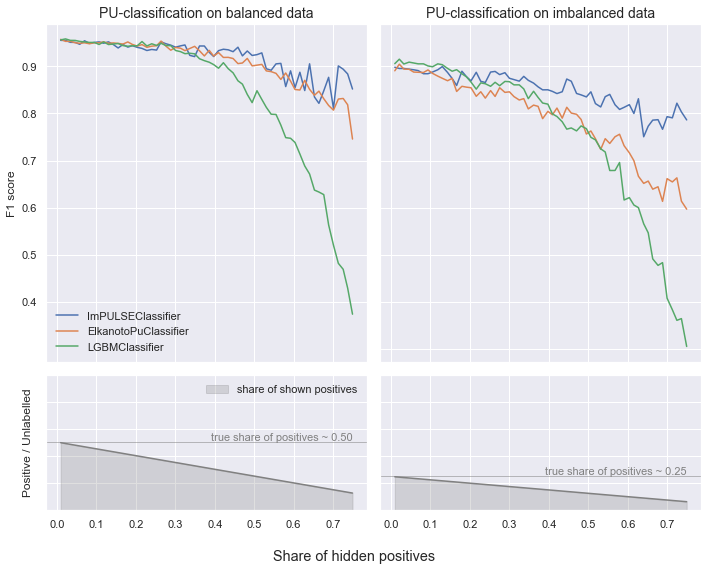

In [13]:
color = 'grey'

# https://stackoverflow.com/a/35881382/6025592
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    sharex=True,
    sharey='row',
    gridspec_kw={'height_ratios': [2.5, 1],
                 'width_ratios': [1, 1]},
    figsize=(10, 8))

for i, (key, val) in enumerate(ratios.items()):

    ax = axes[0, i]

    data = viz_melt[viz_melt['run'] == key].reset_index()

    sns.lineplot(
        data=data,
        x='index',
        y='value',
        hue='variable',
        ax=ax)

    if i == 1:
        ax.legend([], [], frameon=False)

    else:
        ax.legend(title=[], frameon=False)

        # https://stackoverflow.com/a/64830832/6025592
        ax.get_yaxis().get_major_ticks()[1].set_visible(False)

    ax.set_ylabel('F1 score')

    ax.set_title(f'PU-classification on {key} data', fontsize=14)

    ax = axes[1, i]

    ax.plot(val['hidden_to_pos'],
            val['known_to_train'],
            c=color)

    ax.fill_between(
        val['hidden_to_pos'],
        val['known_to_train'],
        y2=0,
        color=color,
        label='share of shown positives',
        alpha=0.25)

    ax.axhline(
        y=1 - runs[key],
        linewidth=0.5,
        c=color)

    ax.text(
        y=1 - runs[key],
        x=val['hidden_to_pos'][-1],
        s=f'true share of positives ~ {1 - runs[key]:.2f}',
        fontsize=11,
        ha='right',
        va='bottom',
        c=color)

    ax.set_yticklabels([])

    ax.set(ylim=(0, 1))

    if i == 1:
        ax.legend([], [], frameon=False)

    else:
        ax.legend(title=[], frameon=False)

        ax.set_ylabel('Positivе / Unlabelled')

fig.supxlabel('Share of hidden positives')

fig.tight_layout()